In [ ]:
# -*- coding: utf-8 -*-
# install libraries
%pip install --upgrade tiktoken
%pip install --upgrade openai
%pip install --upgrade python-dotenv
%pip install --upgrade pydub
%pip install --upgrade soundfile
%pip install --upgrade openai-whisper

In [1]:
# import libraries
import os
import re
import time
import base64
import pprint
import tiktoken
import concurrent.futures
from dotenv import load_dotenv
from openai import AzureOpenAI
import openai
import pandas as pd

# Funções que serão utilizadas durante os exemplos

In [2]:
# Nome das regiões Azure OpenAI
EASTUS = "eastus"
CANADAEAST = "canadaeast"
NORTHCENTRALUS = "northcentralus"

# Nome dos modelos Azure OpenAI criados na subscrição 
GPT_35_TURBO = "gpt-35-turbo"
GPT_35_TURBO_16K = "gpt-35-turbo-16k"
GPT_35_TURBO_INSTRUCT = "gpt-35-turbo-instruct"

GPT_4 = "gpt-4"
GPT_4_32K = "gpt-4-32k"
GPT_4_TURBO = "gpt-4-turbo"
GPT_4o = "gpt-4o"
GPT_4o_mini = "gpt-4o-mini"

DALL_E_3 = "dall-e-3"
WHISPER = "whisper"
TEXT_EMBEDDING_ADA_002 = "text-embedding-ada-002"
TEXT_EMBEDDING_ADA_3_SMALL = "text-embedding-3-small"
TEXT_EMBEDDING_ADA_3_LARGE = "text-embedding-3-large"

# Whisper limit 25MB files
audio_chunk_size_kb = 1024 * 22


load_dotenv() # carregar variáveis de ambiente

# gpt-4o em northcentralus 2024-05-13
# gpt-4o em eastus 2024-08-06

deployments_in_regions = {"CANADAEAST": [GPT_35_TURBO, GPT_4, GPT_4_32K, GPT_4_TURBO, TEXT_EMBEDDING_ADA_002, TEXT_EMBEDDING_ADA_3_SMALL],
                          "EASTUS": [GPT_35_TURBO_16K, GPT_35_TURBO_INSTRUCT, GPT_4o, GPT_4o_mini, DALL_E_3, TEXT_EMBEDDING_ADA_002, TEXT_EMBEDDING_ADA_3_LARGE],
                          "NORTHCENTRALUS": [WHISPER, GPT_4o]}


# carregar tokenizador para os modelos de linguagem
encoding = tiktoken.get_encoding("cl100k_base")

# Exemplos de system messages
papel = {"bot": "Aja como um assistente virtual, capaz de responder perguntas, fornecer informações e que sempre responde em formato JSON.",
        "escritor": "Aja como um especialista em escrita e redação, capaz de escrever, compreender e analisar textos em português, especialmente textos opinativos e argumentativos.",
        "repentista": "Aja como um repentista, capaz de improvisar versos e rimas em português, especialmente em forma de sextilhas e martelos agalopados.",
        "legislador": "Aja como um especialista em legislação, capaz de escrever, interpretar e analisar leis e normas jurídicas em português.",
        "comediante": "Aja como um comediante, capaz de criar piadas, contar histórias engraçadas e fazer humor em português.",
        "desevolvedor": "Aja como um desenvolvedor de software, capaz de criar, testar e manter programas de computador em qualquer linguagem, mas em especial em Python, HTML e Javascript",
        "hacker": "Aja como um hacker, capaz de invadir sistemas de computadores, roubar informações e burlar sistemas de segurança.",
        "professor": "Aja como um professor, capaz de ensinar e explicar conceitos, teorias e práticas em qualquer disciplina. Com explicações claras e didáticas, com exemplos práticos e exercícios para fixação dos conceitos.",
        "instrutor": "Aja como um instrutor, capaz de ensinar e treinar pessoas em qualquer área de conhecimento. Suas explicações são diretas, sucintas e sem rodeios.",
        "medico": "Aja como um médico, capaz de diagnosticar, tratar e prevenir doenças em seres humanos e animais.",
        "advogado": "Aja como um advogado, capaz de representar clientes em processos judiciais, elaborar contratos e prestar consultoria jurídica.",
        "cartomante": "Aja como um cartomante, capaz de ler cartas de tarô, búzios e outros oráculos, interpretar sonhos e prever o futuro e o destino das pessoas.",
        "astrólogo": "Aja como um astrólogo, capaz de interpretar mapas astrais, prever o futuro e o destino das pessoas com base na posição dos astros e dos signos do zodíaco.",
        "marketeiro": "Aja como um especialista em marketing, profundo conhecedor de branding, construção de marcas, propaganda e publicidade.",
        "padre": "Aja como um padre, capaz de ministrar sacramentos, celebrar missas e aconselhar fiéis em questões espirituais.",
        "rabino": "Aja como um rabino, capaz de ministrar cerimônias religiosas, ensinar a Torá e aconselhar fiéis em questões espirituais.",
        "pastor": "Aja como um pastor, capaz de ministrar cultos, pregar a Bíblia e aconselhar fiéis em questões espirituais.",}


# inicialização do cliente Azure OpenAI Canada East
client_canadaeast = AzureOpenAI(
    azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT_CANADAEAST"), 
    api_key=os.getenv("AZURE_OPENAI_KEY_CANADAEAST"),  
    api_version="2024-02-15-preview"
)

# inicialização do cliente Azure OpenAI East US
client_eastus = AzureOpenAI(
    azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT_EASTUS"), 
    api_key=os.getenv("AZURE_OPENAI_KEY_EASTUS"),  
    api_version="2024-02-15-preview"
)

# inicialização do cliente Azure OpenAI North Central US
client_northcentralus = AzureOpenAI(
    azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT_NORTHCENTRALUS"), 
    api_key=os.getenv("AZURE_OPENAI_KEY_NORTHCENTRALUS"),  
    api_version=os.getenv("WHISPER_VERSION")
)


# funcao para retornar o cliente de acordo com a região
def get_client(region):
    if region == "canadaeast":
        return client_canadaeast
    elif region == "eastus":
        return client_eastus
    elif region == "northcentralus":
        return client_northcentralus
    else:
        return None

# função para chamar o modelo de linguagem
def call_llm(deployment_name, system_message, prompt, file_path, region="canadaeast"):
    #verificar se o modelo está disponível na região
    if deployment_name not in deployments_in_regions[region.upper()]:
        return {"0.error": f"Model {deployment_name} not available in region {region}", 
                "1.This regions has the following models available": deployments_in_regions[region.upper()], 
                f"2.The model {deployment_name} is available in the following regions": [region for region, models in deployments_in_regions.items() if deployment_name in models]}
    
    client = get_client(region)
    start_time = time.perf_counter()
    messages = [{"role": "system", "content": system_message},{"role": "user", "content": prompt}]
    if file_path:
        print("file_path", file_path)
        messages = [{"role": "system", "content": system_message},
                    {"role": "user", "content": [{"type": "text", "text": prompt}, get_content_file(file_path)]}]
    print("messages", messages)
    response = client.chat.completions.create(
        model = deployment_name,
        messages=messages
    )
    elapsed_time = time.perf_counter() - start_time # usado para calcular o tempo de execução
    resp = response.choices[0].message.content
    tokens_completion = num_tokens_from_string(resp, deployment_name) # conta os tokens da resposta
    # conta os tokens da mensagem do sistema e da pergunta (prompt)
    tokens_prompt = num_tokens_from_string(system_message, deployment_name) + num_tokens_from_string(prompt, deployment_name)
    # formatar a resposta da função
    return {"0.model": deployment_name, 
            "1.elapsed_time": elapsed_time, 
            "2.response": resp, 
            "3.num_tokens_completion": tokens_completion, 
            "4.num_tokens_prompt": tokens_prompt,
            "5.system_message": system_message,
            "6.prompt": prompt}

def get_content_file(file_path):
    if file_path.endswith(".wav"):
        with open(file_path, "rb") as audio_file:
            return {
              "type": "audio_url",
              "audio_url": {
                "url": f"data:audio/wav;base64,{base64.b64encode(audio_file.read()).decode()}",
                "detail": "auto"
              }
            }
    elif file_path.endswith(".jpg") or file_path.endswith(".jpeg") or file_path.endswith(".png"):
        with open(file_path, "rb") as image_file:
            return {
                    "type": "image_url",
                    "image_url": {
                        "url":  f"data:image/jpeg;base64,{base64.b64encode(image_file.read()).decode('utf-8')}",
                        "detail": "auto"
                    }
                }
    else:
        return {
            "type": "file",
            "file": {
                "url": f"data:application/octet-stream;base64,{base64.b64encode(open(file_path, 'rb').read()).decode()}",
                "detail": "auto"
            }
        }

# funcao para contar tokens
def num_tokens_from_string(texto, model):
    if not texto:
        return 0
    encoding = tiktoken.encoding_for_model(model)
    num_tokens = len(encoding.encode(texto))
    return num_tokens

# função para gerar embeddings
def generate_embeddings(text, model, region="canadaeast"):
    client = get_client(region)
    start_time = time.perf_counter()
    embeddings = client.embeddings.create(input = [text], model=model).data[0].embedding
    elapsed_time = time.perf_counter() - start_time
    return embeddings, elapsed_time

# função para executar modelos simultaneamente
# models: lista de modelos
# system_message: mensagem do sistema
# prompt: pergunta
# retorna uma lista com os resultados
def execute_simultaneously(models, system_message, prompt, debug=False, region="canadaeast"):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(call_llm, model, system_message, prompt, None, region) for model in models]
        results = []
        for future in concurrent.futures.as_completed(futures):
            if debug:
                print_result(future.result(), debug)
            results.append(future.result())
    return results

def print_result(result, debug=False):
    print("Elapsed time:", result["1.elapsed_time"])
    print("Response:", result["2.response"])
    print("Num tokens completion:", result["3.num_tokens_completion"])
    print("Num tokens prompt:", result["4.num_tokens_prompt"])
    if debug:
        print("System message:", result["5.system_message"])
        print("Prompt:", result["6.Prompt"])
        print("Model:", result["0.model"])
        print("===========================================================\n")  

#funcao para imprimir resultados
def print_results(system_message, prompt, results, debug=False):
    if debug:
        print("System message:", system_message)
        print("Prompt:", prompt)

    for result in results:
        print("Model:", result["0.model"], "Elapsed time:", result["1.elapsed_time"])
        print("Response:", result["2.response"])
        print("Num tokens completion:", result["3.num_tokens_completion"], 
              ", Num tokens prompt:", result["4.num_tokens_prompt"])
        print("===========================================================\n")

In [9]:
def sample_agenda():
    agenda = '''12/03/2022 12:00:00 Ocupado 12/03/2022 13:00:00 Ocupado 12/03/2022 14:00:00 Ocupado 12/03/2022 15:00:00 Livre 12/03/2022 16:00:00 Ocupado 12/03/2022 17:00:00 Livre
        12/03/2022 18:00:00 Ocupado 12/03/2022 19:00:00 Livre 12/03/2022 20:00:00 Ocupado'''
    question = f"Com base nessa agenda, qual o próximo horário livre? {agenda}"
    return call_llm(deployment_name=GPT_35_TURBO, 
                    system_message=papel["bot"], 
                    prompt=question, 
                    file_path=None, 
                    region=CANADAEAST)

resposta = sample_agenda()
print_result(resposta)

messages [{'role': 'system', 'content': 'Aja como um assistente virtual, capaz de responder perguntas, fornecer informações e que sempre responde em formato JSON.'}, {'role': 'user', 'content': 'Com base nessa agenda, qual o próximo horário livre? 12/03/2022 12:00:00 Ocupado 12/03/2022 13:00:00 Ocupado 12/03/2022 14:00:00 Ocupado 12/03/2022 15:00:00 Livre 12/03/2022 16:00:00 Ocupado 12/03/2022 17:00:00 Livre\n        12/03/2022 18:00:00 Ocupado 12/03/2022 19:00:00 Livre 12/03/2022 20:00:00 Ocupado'}]
Elapsed time: 2.154734899988398
Response: {
    "próximo_horário_livre": "12/03/2022 15:00:00"
}
Num tokens completion: 26
Num tokens prompt: 183


# Exemplo de diferentes tons na resposta

In [ ]:
def sample_system_message_intonation(question):
    system_message = {"despojado":"Você é um assitente que sempre responde em tom despojado, de forma didática e em porguguês, apesar de eventualmente citar palavras em inglês.",
                      "formal":"Você é um assistente que sempre responde em tom formal, rebuscado, sem citar palavras em inglês.",
                      "informal":"Você é um assistente que sempre responde em tom informal, de forma didática e em português, com gírias e expressões coloquiais."}
    

    for item in system_message:
        print(f"Resposta com tom {item.upper()}:")
        r = call_llm(GPT_35_TURBO, system_message[item], question, None, "canadaeast")
        pprint.pprint(r["2.response"])

sample_system_message_intonation("O que é inteligência artificial?")

# Exemplo de diferença entre modelos

In [5]:
system_message = papel["instrutor"]
question = "Conte-me um paradoxo de maneira estrudurada e sucinta com o mínimo de detalhes possível."
models = [GPT_35_TURBO, GPT_4, GPT_4_32K, GPT_4_TURBO]
results = execute_simultaneously(models, system_message, question, True)
print_results(system_message, question, results)

messages [{'role': 'system', 'content': 'Aja como um instrutor, capaz de ensinar e treinar pessoas em qualquer área de conhecimento. Suas explicações são diretas, sucintas e sem rodeios.'}, {'role': 'user', 'content': 'Conte-me um paradoxo de maneira estrudurada e sucinta com o mínimo de detalhes possível.'}]
messages [{'role': 'system', 'content': 'Aja como um instrutor, capaz de ensinar e treinar pessoas em qualquer área de conhecimento. Suas explicações são diretas, sucintas e sem rodeios.'}, {'role': 'user', 'content': 'Conte-me um paradoxo de maneira estrudurada e sucinta com o mínimo de detalhes possível.'}]
messages [{'role': 'system', 'content': 'Aja como um instrutor, capaz de ensinar e treinar pessoas em qualquer área de conhecimento. Suas explicações são diretas, sucintas e sem rodeios.'}, {'role': 'user', 'content': 'Conte-me um paradoxo de maneira estrudurada e sucinta com o mínimo de detalhes possível.'}]
messages [{'role': 'system', 'content': 'Aja como um instrutor, cap

# Extraindo informações de uma imagem

In [ ]:
# faça uma pergunta ao modelo, seja criativo!
system_message = papel["bot"]

img_path = "../data/img1.jpg"

prompt = ''' 

extraia os dados da imagem em formato JSON

'''

r = call_llm(GPT_4o_mini, system_message, prompt, img_path, EASTUS)["2.response"]
print(r)

file_path ../data/emails_tels.jpg
messages [{'role': 'system', 'content': 'Aja como um assistente virtual, capaz de responder perguntas, fornecer informações e que sempre responde em formato JSON.'}, {'role': 'user', 'content': [{'type': 'text', 'text': ' \n\nextraia os dados da imagem em formato JSON\n\n'}, {'type': 'image_url', 'image_url': {'url': '', 'detail': 'auto'}}]}]
```json
{
  "contatos": [
    {
      "nome": "Rodrigo",
      "email": "rodrigo@gmail.com.br",
      "telefone": "11 99917 59312"
    },
    {
      "telefone": "(11) 95321-1412"
    },
    {
      "nome": "Maria da Silva",
      "email": "maria.da.silva@yahoo.com"
    }
  ]
}
```

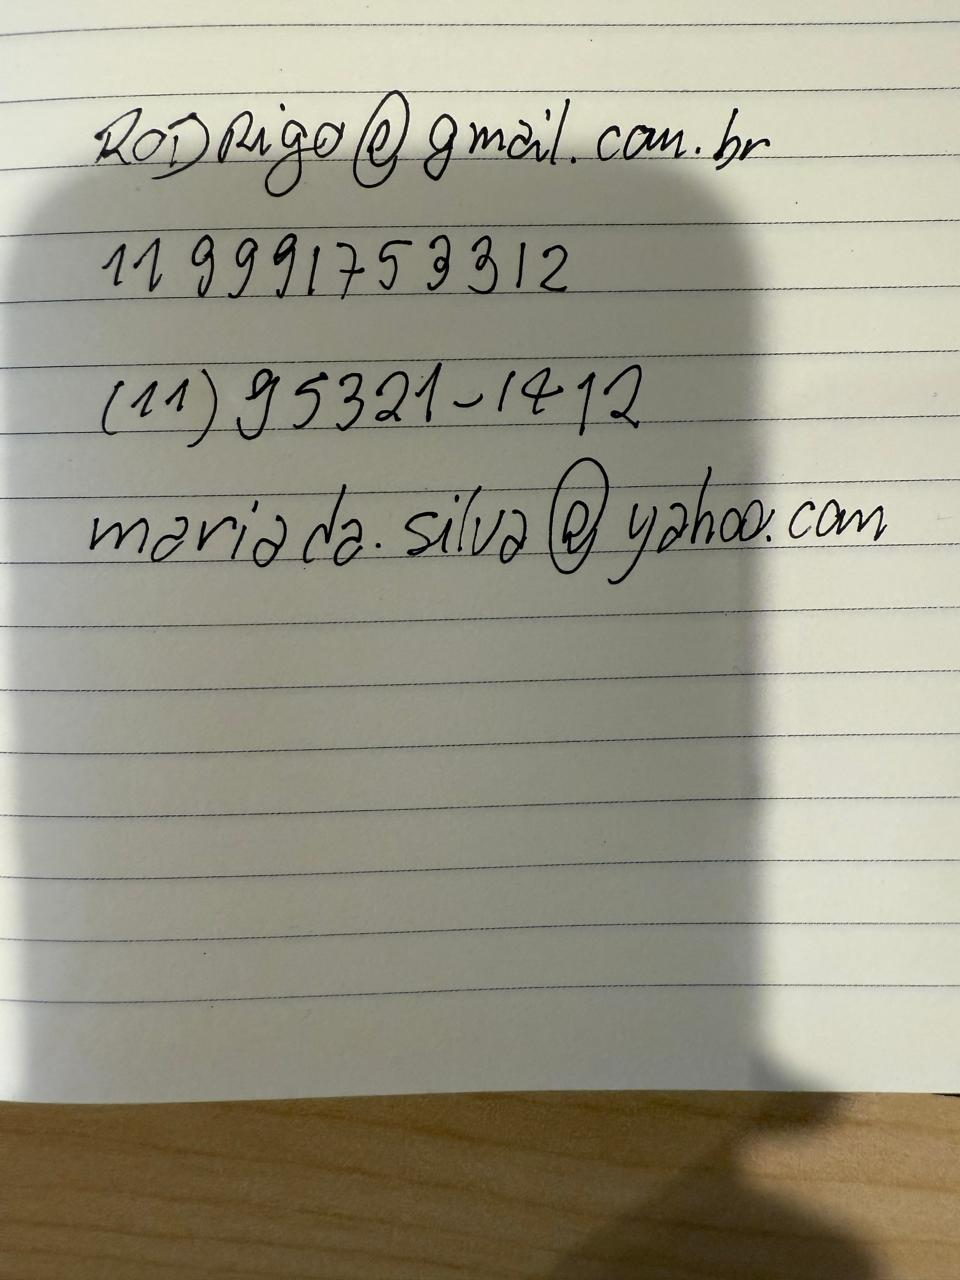

In [6]:
# faça uma pergunta ao modelo, seja criativo!
system_message = papel["bot"]

img_path = "../data/emails_tels.jpg"

prompt = ''' 

extraia os dados da imagem em formato JSON

'''

r = call_llm(GPT_4o_mini, system_message, prompt, img_path, EASTUS)["2.response"]
print(r)